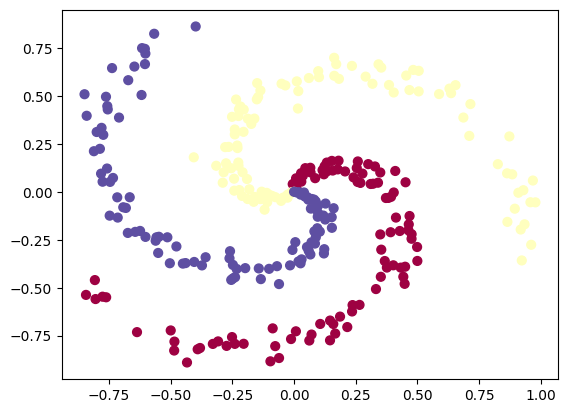

In [2]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [5]:
X.shape,y.shape, y[:5]

((300, 2), (300,), array([0, 0, 0, 0, 0], dtype=uint8))

In [48]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy
from helper_functions import plot_decision_boundary

In [6]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

(torch.Size([240, 2]),
 torch.Size([240]),
 torch.Size([60, 2]),
 torch.Size([60]))

In [9]:
device="cuda"

In [44]:
class MultiClassModel(nn.Module):
    def __init__(self,input_features,hidden_features,output_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=output_features)
            
        )
    def forward(self,X):
        return self.model(X)

model = MultiClassModel(2,10,3).to(device)
model

MultiClassModel(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [45]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.01)
accuracy = Accuracy(task='multiclass', num_classes=3).to(device)

In [15]:
with torch.inference_mode():
    y_logits = model(X_test.to(device))
y_logits[:5]

tensor([[ 0.2454,  0.1375,  0.0170],
        [ 0.2391,  0.1338,  0.0155],
        [ 0.2383,  0.1329,  0.0155],
        [ 0.2345,  0.1227, -0.0026],
        [ 0.2285,  0.1170,  0.0175]], device='cuda:0')

In [23]:
y_pred = torch.softmax(y_logits,dim=1)
y_pred[:5]

tensor([[0.3713, 0.3333, 0.2954],
        [0.3704, 0.3334, 0.2962],
        [0.3703, 0.3333, 0.2964],
        [0.3727, 0.3333, 0.2940],
        [0.3698, 0.3308, 0.2994]], device='cuda:0')

In [24]:
torch.argmax(y_pred,dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [25]:
y_test

tensor([0, 1, 2, 0, 0, 2, 1, 2, 2, 1, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 2,
        0, 2, 2, 2, 2, 0, 1, 1, 1, 2, 0, 1, 2, 2, 1, 0, 1, 1, 0, 2, 1, 1, 2, 1,
        2, 0, 2, 1, 2, 1, 0, 2, 1, 2, 1, 2])

In [52]:
epochs = 100
X_train,X_test = X_train.to(device), X_test.to(device)
y_train,y_test = y_train.to(device), y_test.to(device)
model.to(device)
for epoch in range(epochs):
    model.train()
    y_logits = model(X_train)
    y_pred = torch.softmax(y_logits, dim =1).argmax(dim=1)
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_pred,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test)
        y_test_pred = torch.softmax(y_test_logits,dim=1).argmax(dim=1)
        test_loss =loss_fn(y_test_logits, y_test)
        test_acc = accuracy(y_test_pred, y_test)

    if epoch%10 ==0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Test loss: {test_loss:.5f} | Train Acc: {acc:.2f} | Test acc: {test_acc:.2f}")

Epoch: 0 | Train loss: 0.18617 | Test loss: 0.23112 | Train Acc: 0.93 | Test acc: 0.87
Epoch: 10 | Train loss: 0.13491 | Test loss: 0.17083 | Train Acc: 0.95 | Test acc: 0.98
Epoch: 20 | Train loss: 0.10110 | Test loss: 0.13468 | Train Acc: 0.98 | Test acc: 0.98
Epoch: 30 | Train loss: 0.07921 | Test loss: 0.10679 | Train Acc: 0.98 | Test acc: 0.98
Epoch: 40 | Train loss: 0.06533 | Test loss: 0.08940 | Train Acc: 0.99 | Test acc: 1.00
Epoch: 50 | Train loss: 0.05651 | Test loss: 0.08039 | Train Acc: 0.99 | Test acc: 0.98
Epoch: 60 | Train loss: 0.05002 | Test loss: 0.07119 | Train Acc: 0.99 | Test acc: 1.00
Epoch: 70 | Train loss: 0.04513 | Test loss: 0.06472 | Train Acc: 0.99 | Test acc: 1.00
Epoch: 80 | Train loss: 0.04140 | Test loss: 0.05982 | Train Acc: 0.99 | Test acc: 1.00
Epoch: 90 | Train loss: 0.03843 | Test loss: 0.05579 | Train Acc: 0.99 | Test acc: 1.00


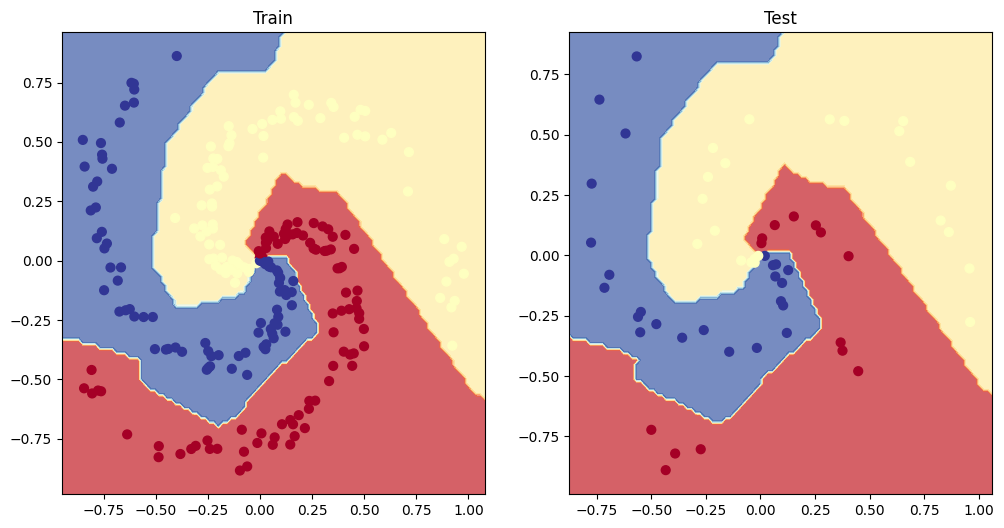

In [53]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model, X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model, X_test,y_test)
